# Đồ án Khai thác Dữ liệu - Main Workflow

Notebook này thực hiện toàn bộ pipeline từ tiền xử lý đến đánh giá mô hình.

## Quy trình:
1. Load và kiểm tra dataset
2. Thống kê mô tả
3. Tiền xử lý dữ liệu
4. Training 2 mô hình khác loại
5. Đánh giá và so sánh mô hình
6. Lưu kết quả



In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import os

# Add parent directory to path để import các module
current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

from src.utils.descriptive_stats import generate_descriptive_stats, save_stats_to_markdown, save_stats_to_csv
from src.preprocess.preprocessing import DataPreprocessor, split_data
from src.models.train_model import ModelTrainer
from src.evaluation.evaluate import ModelEvaluator

# Set style
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('seaborn')
sns.set_palette("husl")

print("Đã import các thư viện cần thiết")



Đã import các thư viện cần thiết


## 1. Load và Kiểm tra Dataset

**Lưu ý**: Đặt file dataset vào `data/raw/` trước khi chạy



In [2]:
# Load dataset Student Performance
data_path = "../data/raw/student.csv"

try:
    df = pd.read_csv(data_path)
    print(f"✅ Đã load dataset: {df.shape[0]} dòng, {df.shape[1]} cột")
    print(f"\nCác cột: {list(df.columns)}")
    print(f"\n5 dòng đầu:")
    df.head()
except FileNotFoundError:
    print(f"❌ Không tìm thấy file: {data_path}")
    print("Vui lòng đặt dataset vào data/raw/")



✅ Đã load dataset: 649 dòng, 33 cột

Các cột: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']

5 dòng đầu:


## 2. Thống kê Mô tả

Tạo thống kê mô tả tự động và lưu vào report/



In [3]:
# Kiểm tra dataset hợp lệ (>= 5 cột, >= 500 dòng)
if df.shape[1] >= 5 and df.shape[0] >= 500:
    print("✅ Dataset hợp lệ")
else:
    print(f"⚠️ Cảnh báo: Dataset có {df.shape[0]} dòng, {df.shape[1]} cột")
    print("Yêu cầu: >= 500 dòng và >= 5 cột")

# Tạo thống kê mô tả
stats = generate_descriptive_stats(df)

# Lưu thống kê
save_stats_to_markdown(stats, "../report/descriptive_stats.md")
save_stats_to_csv(df, "../src/utils/descriptive_stats.csv")

print("✅ Đã tạo và lưu thống kê mô tả")



✅ Dataset hợp lệ
✅ Đã tạo và lưu thống kê mô tả


## 3. Tiền Xử lý Dữ liệu

Xử lý missing values, outliers, encoding, scaling



In [4]:
# Xác định target column: G3 (final grade)
target_column = "G3"

# Loại bỏ G1 và G2 vì có tương quan mạnh với G3 (theo mô tả dataset)
# Để dự đoán hữu ích hơn, chỉ dùng các features khác
columns_to_drop = [target_column, "G1", "G2"]

if target_column not in df.columns:
    print(f"⚠️ Không tìm thấy cột '{target_column}'")
    print(f"Các cột có sẵn: {list(df.columns)}")
else:
    # Tách features và target
    X = df.drop(columns=columns_to_drop)
    y = df[target_column]
    
    print(f"Features: {X.shape}")
    print(f"Target: {y.shape}")
    print(f"Đã loại bỏ G1 và G2 để tránh data leakage")
    
    # Xác định loại bài toán
    # Nếu target là object/category -> classification
    # Nếu target là numeric và có nhiều giá trị unique (>10) -> regression
    # Nếu target là numeric nhưng ít giá trị unique (<10) -> classification
    if y.dtype in ['object', 'category']:
        problem_type = 'classification'
        print("📊 Loại bài toán: Classification")
    elif y.dtype in ['int64', 'float64'] and y.nunique() > 10:
        problem_type = 'regression'
        print("📊 Loại bài toán: Regression")
    else:
        problem_type = 'classification'
        print("📊 Loại bài toán: Classification")



Features: (649, 30)
Target: (649,)
Đã loại bỏ G1 và G2 để tránh data leakage
📊 Loại bài toán: Regression


In [5]:
# Khởi tạo preprocessor
# Điều chỉnh các tham số theo nhu cầu:
# - missing_strategy: 'mean', 'median', 'most_frequent', 'interpolation'
# - outlier_method: 'IQR', 'Z-score'
# - encoding_method: 'onehot', 'label', 'ordinal'
# - scaling_method: 'standard', 'minmax'

preprocessor = DataPreprocessor(
    missing_strategy='mean',
    outlier_method='IQR',
    encoding_method='onehot',
    scaling_method='standard'
)

# Fit và transform
X_processed = preprocessor.fit_transform(X)

print(f"✅ Đã xử lý dữ liệu: {X_processed.shape}")

# Lưu preprocessor
preprocessor.save_preprocessor("../src/models/preprocessor.joblib")
print("✅ Đã lưu preprocessor")



✅ Đã xử lý dữ liệu: (649, 39)
✅ Đã lưu preprocessor


D:\coding\data_mining\src\preprocess\preprocessing.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed[col].fillna(df[col].mean(), inplace=True)


In [6]:
# Chia train/test (80/20)
# Nếu classification và mỗi class có >= 2 samples, dùng stratify
if problem_type == 'classification':
    # Kiểm tra xem có thể dùng stratify không
    class_counts = y.value_counts()
    min_class_count = class_counts.min()
    if min_class_count >= 2:
        stratify = y
        print(f"Sử dụng stratify (min class count: {min_class_count})")
    else:
        stratify = None
        print(f"Không dùng stratify (có class chỉ có {min_class_count} sample)")
else:
    stratify = None

X_train, X_test, y_train, y_test = split_data(
    X_processed, y, 
    test_size=0.2, 
    stratify=stratify,
    random_state=42
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Lưu dữ liệu đã xử lý
Path("../data/processed").mkdir(parents=True, exist_ok=True)
pd.concat([X_train, y_train], axis=1).to_csv("../data/processed/train.csv", index=False)
pd.concat([X_test, y_test], axis=1).to_csv("../data/processed/test.csv", index=False)
print("✅ Đã lưu dữ liệu đã xử lý")



Train set: 519 samples
Test set: 130 samples
✅ Đã lưu dữ liệu đã xử lý


## 4. Training Mô hình

Training 2 mô hình khác loại với hyperparameter tuning



In [7]:
# Model A: Random Forest
print("=" * 50)
print("Training Model A: Random Forest")
print("=" * 50)

trainer_a = ModelTrainer(
    model_type=problem_type,
    model_name='random_forest'
)

trainer_a.train(X_train, y_train, tuning_method='grid', cv=5)
print(f"Best params: {trainer_a.best_params}")

# Đánh giá Model A
metrics_a, y_pred_a = trainer_a.evaluate(X_test, y_test)
print(f"\nMetrics Model A:")
for key, value in metrics_a.items():
    print(f"  {key}: {value:.4f}")

# Lưu Model A
model_a_path, metadata_a_path = trainer_a.save_model(
    f"../src/models/model_a_{problem_type}.joblib"
)
print(f"✅ Đã lưu Model A: {model_a_path}")



Training Model A: Random Forest
Best params: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}

Metrics Model A:
  rmse: 2.9265
  mae: 2.1838
  mape: 1352578665.0390
  r2: 0.1218
✅ Đã lưu Model A: ../src/models/model_a_regression.joblib


In [8]:
# Model B: SVM (khác loại với Model A)
print("=" * 50)
print("Training Model B: SVM")
print("=" * 50)

trainer_b = ModelTrainer(
    model_type=problem_type,
    model_name='svm'
)

trainer_b.train(X_train, y_train, tuning_method='random', cv=5, n_iter=20)
print(f"Best params: {trainer_b.best_params}")

# Đánh giá Model B
metrics_b, y_pred_b = trainer_b.evaluate(X_test, y_test)
print(f"\nMetrics Model B:")
for key, value in metrics_b.items():
    print(f"  {key}: {value:.4f}")

# Lưu Model B
model_b_path, metadata_b_path = trainer_b.save_model(
    f"../src/models/model_b_{problem_type}.joblib"
)
print(f"✅ Đã lưu Model B: {model_b_path}")



Training Model B: SVM
Best params: {'kernel': 'rbf', 'gamma': 'scale', 'C': 1}

Metrics Model B:
  rmse: 2.9100
  mae: 2.1159
  mape: 1750378031.1787
  r2: 0.1316
✅ Đã lưu Model B: ../src/models/model_b_regression.joblib


## 5. Đánh giá và So sánh Mô hình

Tính metrics và tạo visualizations



Đã lưu hình vào: ../src/evaluation/model_a_evaluation.png
Đã lưu kết quả vào: ../src/evaluation/model_a_results.json


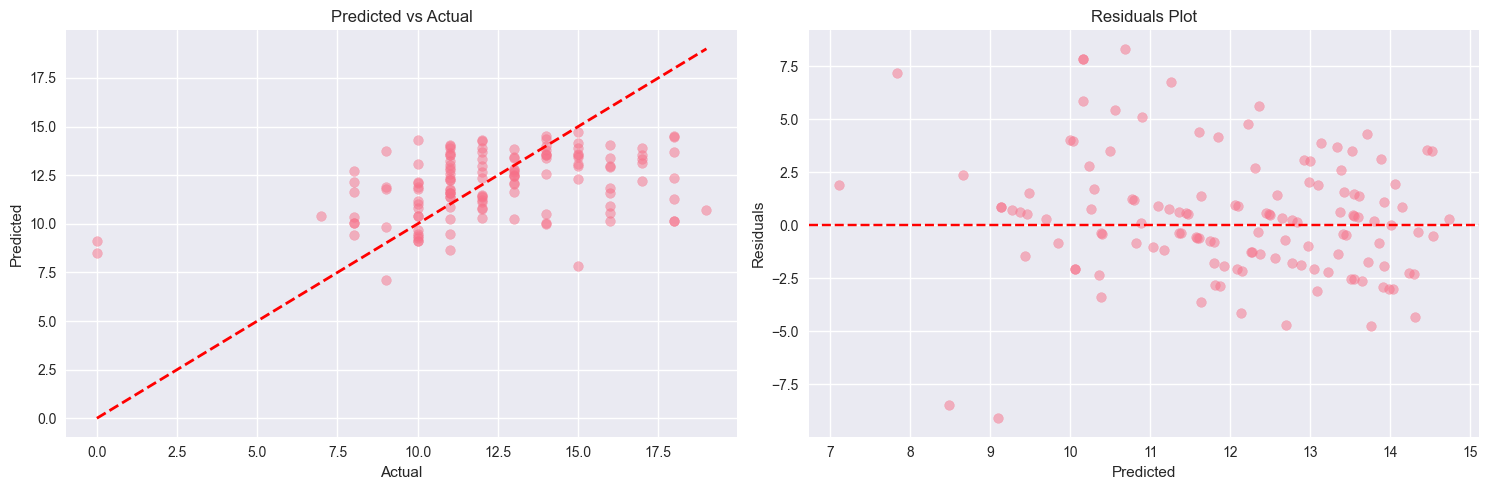

In [9]:
# Đánh giá Model A
evaluator_a = ModelEvaluator(model_type=problem_type)

if problem_type == 'classification':
    metrics_a, fig_a = evaluator_a.evaluate_classification(
        y_test, y_pred_a, 
        save_path="../src/evaluation/model_a_evaluation.png"
    )
elif problem_type == 'regression':
    metrics_a, fig_a = evaluator_a.evaluate_regression(
        y_test, y_pred_a,
        save_path="../src/evaluation/model_a_evaluation.png"
    )

evaluator_a.save_results("../src/evaluation/model_a_results.json")
plt.show()



Đã lưu hình vào: ../src/evaluation/model_b_evaluation.png
Đã lưu kết quả vào: ../src/evaluation/model_b_results.json


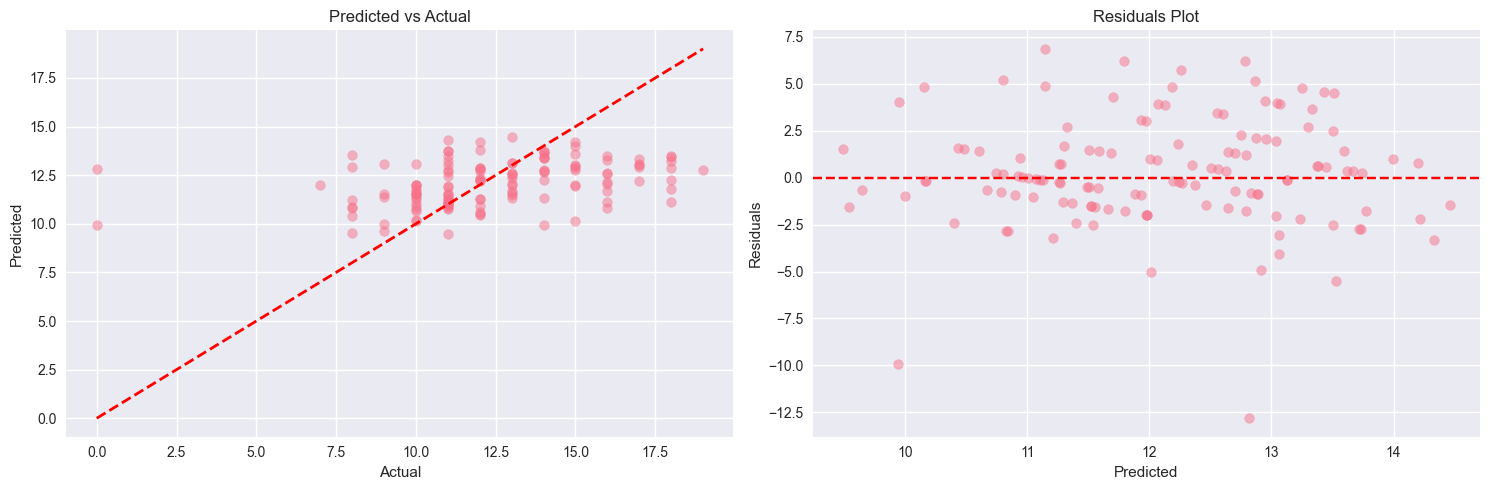

In [10]:
# Đánh giá Model B
evaluator_b = ModelEvaluator(model_type=problem_type)

if problem_type == 'classification':
    metrics_b, fig_b = evaluator_b.evaluate_classification(
        y_test, y_pred_b,
        save_path="../src/evaluation/model_b_evaluation.png"
    )
elif problem_type == 'regression':
    metrics_b, fig_b = evaluator_b.evaluate_regression(
        y_test, y_pred_b,
        save_path="../src/evaluation/model_b_evaluation.png"
    )

evaluator_b.save_results("../src/evaluation/model_b_results.json")
plt.show()



Đã lưu hình vào: ../src/evaluation/model_comparison.png

📊 So sánh Mô hình:
                             rmse       mae          mape        r2
Model A (Random Forest)  2.926460  2.183759  1.352579e+09  0.121778
Model B (SVM)            2.909981  2.115920  1.750378e+09  0.131641


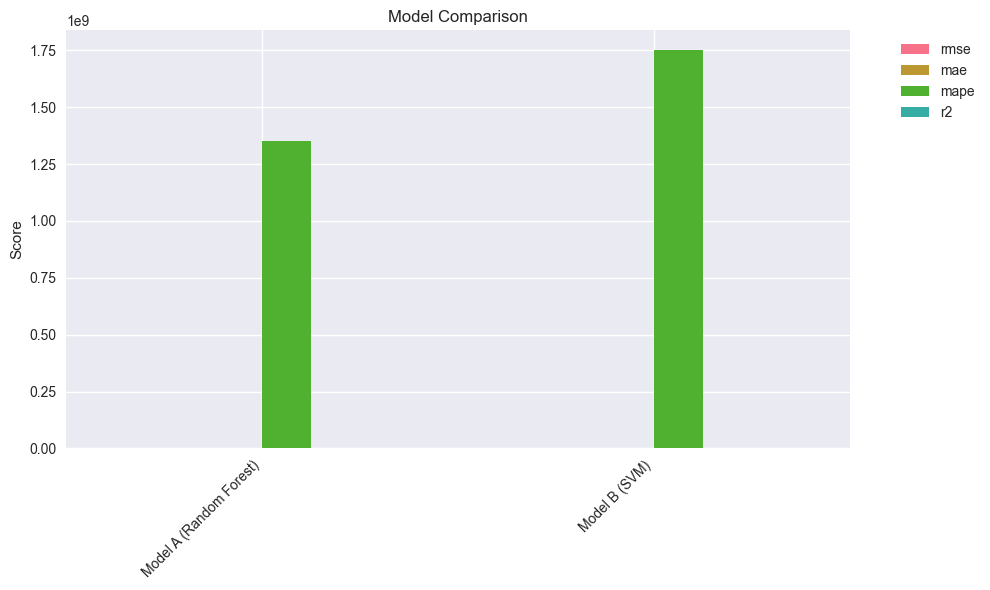

In [11]:
# So sánh 2 mô hình
comparison_results = {
    'Model A (Random Forest)': metrics_a,
    'Model B (SVM)': metrics_b
}

comparison_df, fig_compare = evaluator_a.compare_models(
    comparison_results,
    save_path="../src/evaluation/model_comparison.png"
)

print("\n📊 So sánh Mô hình:")
print(comparison_df)
plt.show()



## 6. Tạo Báo cáo Đánh giá

Lưu báo cáo đánh giá vào report/evaluation.md



In [12]:
# Tạo báo cáo đánh giá
report_path = "../report/evaluation.md"
Path(report_path).parent.mkdir(parents=True, exist_ok=True)

with open(report_path, 'w', encoding='utf-8') as f:
    f.write("# Báo cáo Đánh giá Mô hình\n\n")
    f.write(f"## Loại bài toán: {problem_type.upper()}\n\n")
    
    f.write("## Model A: Random Forest\n\n")
    f.write("### Metrics:\n")
    for key, value in metrics_a.items():
        f.write(f"- **{key}**: {value:.4f}\n")
    f.write("\n")
    
    f.write("## Model B: SVM\n\n")
    f.write("### Metrics:\n")
    for key, value in metrics_b.items():
        f.write(f"- **{key}**: {value:.4f}\n")
    f.write("\n")
    
    f.write("## So sánh\n\n")
    f.write("| Metric | Model A | Model B |\n")
    f.write("|--------|---------|----------|\n")
    for metric in metrics_a.keys():
        f.write(f"| {metric} | {metrics_a[metric]:.4f} | {metrics_b[metric]:.4f} |\n")
    f.write("\n")
    
    # Xác định mô hình tốt hơn
    if problem_type == 'classification':
        best_metric = 'accuracy'
    else:
        best_metric = 'r2' if 'r2' in metrics_a else 'rmse'
    
    if best_metric in metrics_a and best_metric in metrics_b:
        if problem_type == 'regression' and best_metric == 'rmse':
            best_model = 'A' if metrics_a[best_metric] < metrics_b[best_metric] else 'B'
        else:
            best_model = 'A' if metrics_a[best_metric] > metrics_b[best_metric] else 'B'
        f.write(f"## Kết luận\n\n")
        f.write(f"Mô hình tốt hơn dựa trên {best_metric}: **Model {best_model}**\n")

print(f"✅ Đã tạo báo cáo: {report_path}")



✅ Đã tạo báo cáo: ../report/evaluation.md


## Hoàn thành!

Đã thực hiện xong pipeline:
- ✅ Kiểm tra và thống kê dataset
- ✅ Tiền xử lý dữ liệu
- ✅ Training 2 mô hình khác loại
- ✅ Đánh giá và so sánh mô hình
- ✅ Lưu kết quả

**Các file đã tạo:**
- `report/descriptive_stats.md` - Thống kê mô tả
- `src/models/preprocessor.joblib` - Preprocessor
- `src/models/model_a_*.joblib` - Model A
- `src/models/model_b_*.joblib` - Model B
- `src/evaluation/*.png` - Hình ảnh đánh giá
- `src/evaluation/*.json` - Kết quả metrics
- `report/evaluation.md` - Báo cáo đánh giá

